<H1>Analisis Japanese GP 2024</H1>
<p><strong>#TODO:</strong> penjelasan dfari tiap analisis dan koding </p> 

In [1]:
#melakukan import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import fastf1
import fastf1.plotting
import math
from datetime import timedelta
import matplotlib as mpl

from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap
from adjustText import adjust_text

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler,Normalizer

fastf1.plotting.setup_mpl()

In [2]:
#mendefinisikan fungsi

def getDuration(x): #mendapatkan durasi dari poin A ke B
    min=x.min()
    max=x.max()
    return max-min


def rotate_matrix (x, y, angle, x_shift=0, y_shift=0, units="DEGREES"): #melakukan proses rotasi matriks numpy
    """
    Rotates a point in the xy-plane counterclockwise through an angle about the origin
    https://en.wikipedia.org/wiki/Rotation_matrix
    :param x: x coordinate
    :param y: y coordinate
    :param x_shift: x-axis shift from origin (0, 0)
    :param y_shift: y-axis shift from origin (0, 0)
    :param angle: The rotation angle in degrees
    :param units: DEGREES (default) or RADIANS
    :return: Tuple of rotated x and y
    """

    # Shift to origin (0,0)
    x = x - x_shift
    y = y - y_shift

    # Convert degrees to radians
    if units == "DEGREES":
        angle = math.radians(angle)

    # Rotation matrix multiplication to get rotated x & y
    xr = (x * math.cos(angle)) - (y * math.sin(angle)) + x_shift
    yr = (x * math.sin(angle)) + (y * math.cos(angle)) + y_shift

    return xr, yr

def rotate(xy, *, angle): #melakukan proses rotasi matriks numpy
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)

<H2> Analisis Kualifikasi </H2>

In [4]:
#memuat data dari fastf1

japgp_q_2024=fastf1.get_session(2024,'japan','q')#data kualifikasi
japgp_q_2024.load()

req         WARNING 	DEFAULT CACHE ENABLED! (189.38 MB) C:\Users\haryo\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Japanese Grand Prix - Qualifying [v3.3.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '4', '55', '14', '81', '44', '16', '63', '22', '3', '27', '77', '23', '31', '18', '10', '20', '2', '24']


In [5]:
#mengambil lap tercepat masing - masing pembalap dan menambahkan informasi lainnya dalam dataframe
fastest_quali=pd.DataFrame()
for drv in japgp_q_2024.drivers:
    df_temp=pd.DataFrame(japgp_q_2024.laps.pick_driver(drv).pick_accurate().pick_wo_box().pick_fastest().get_telemetry())
    df_temp['drvName']=japgp_q_2024.get_driver(drv).Abbreviation
    df_temp['teamName']=japgp_q_2024.get_driver(drv).TeamName
    df_temp['teamColor']='#'+japgp_q_2024.get_driver(drv).TeamColor
    fastest_quali=pd.concat([fastest_quali,df_temp])

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core      

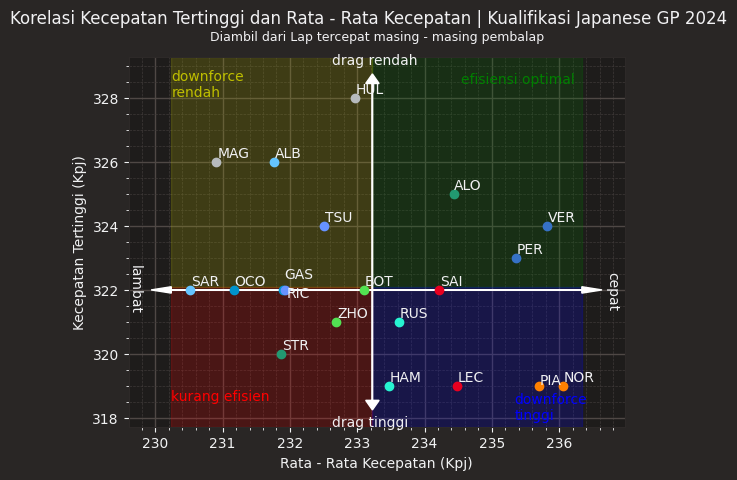

In [6]:
#visualisasi kuadran - kualifikasi
from adjustText import adjust_text
test=fastest_quali.groupby(['drvName','teamName','teamColor']).agg(maxSpeed=('Speed','max'),avgSpeed=('Speed','mean')).reset_index()
fig,ax=plt.subplots()

[ax.scatter(row['avgSpeed'],row['maxSpeed'],color=row['teamColor'],zorder=10) for i,row in test.iterrows()]
texts=[ax.annotate(row['drvName'],[row['avgSpeed'],row['maxSpeed']],zorder=10) for i,row in test.iterrows()]
#ax.axvline(test['avgSpeed'].mean(),color='lightgray')
#ax.axhline(test['maxSpeed'].mean(),color='lightgray')
xlims=ax.get_xlim()
ylims=ax.get_ylim()
maxSpeed_center=(test['maxSpeed'].mean()-min(ylims))/(max(ylims)-min(ylims))

ax.axvspan(xmin=test['avgSpeed'].mean(),xmax=max(xlims),ymin=maxSpeed_center,color='g',alpha=0.2)
ax.axvspan(xmax=test['avgSpeed'].mean(),xmin=min(xlims),ymax=maxSpeed_center,color='r',alpha=0.2)
ax.axvspan(xmax=test['avgSpeed'].mean(),xmin=min(xlims),ymin=maxSpeed_center,color='y',alpha=0.2)
ax.axvspan(xmin=test['avgSpeed'].mean(),xmax=max(xlims),ymax=maxSpeed_center,color='b',alpha=0.2)

ax.arrow(test['avgSpeed'].mean(),min(ylims),0,max(ylims)-min(ylims),color='white',head_width=0.2)
ax.arrow(test['avgSpeed'].mean(),max(ylims),0,-(max(ylims)-min(ylims)),color='white',head_width=0.2)
ax.arrow(min(xlims),test['maxSpeed'].mean()-0.3,max(xlims)-min(xlims),0,color='white',head_width=0.2)
ax.arrow(max(xlims),test['maxSpeed'].mean()-0.3,-(max(xlims)-min(xlims)),0,color='white',head_width=0.2)

ax.text(max(xlims)+0.4,test['maxSpeed'].mean()+0.3,'cepat',rotation=270,rotation_mode='anchor')
ax.text(min(xlims)-0.6,test['maxSpeed'].mean()+0.5,'lambat',rotation=270,rotation_mode='anchor')

ax.text(test['avgSpeed'].mean()-.6,max(ylims)+.6,'drag rendah')
ax.text(test['avgSpeed'].mean()-.6,min(ylims)-0.8,'drag tinggi')
props=dict(boxstyle='round',facecolor='w',alpha=0.5)
ax.text(min(xlims),min(ylims),'kurang efisien',color='r')
ax.text(max(xlims)-1,min(ylims)-0.6,'downforce\ntinggi',color='b')
ax.text(min(xlims),max(ylims)-0.4,'downforce\nrendah',color='y')
ax.text(max(xlims)-1.8,max(ylims),'efisiensi optimal',color='g')

ax.set_xlabel('Rata - Rata Kecepatan (Kpj)')
ax.set_ylabel('Kecepatan Tertinggi (Kpj)')
adjust_text(texts)
plt.suptitle('Korelasi Kecepatan Tertinggi dan Rata - Rata Kecepatan | Kualifikasi Japanese GP 2024')
plt.title('Diambil dari Lap tercepat masing - masing pembalap',fontsize=9)

plt.show()

In [8]:
avg_vs_min_Laptime=japgp_q_2024.laps.pick_accurate().pick_wo_box()[['LapTime','Driver','DriverNumber']].groupby(['Driver','DriverNumber']).agg(bestLap=('LapTime','min'),avgLap=('LapTime','mean')).reset_index()
avg_vs_min_Laptime['color']=avg_vs_min_Laptime['DriverNumber'].apply(lambda x: '#'+japgp_q_2024.get_driver(x).TeamColor)

scaler=StandardScaler()
avg_vs_min_Laptime['bestLapSecs']=avg_vs_min_Laptime['bestLap'].dt.total_seconds()
avg_vs_min_Laptime['avgLapSecs']=avg_vs_min_Laptime['avgLap'].dt.total_seconds()

train=avg_vs_min_Laptime[['bestLapSecs','avgLapSecs']]
transformed=scaler.fit_transform(train)
clustering = DBSCAN(eps=0.44, min_samples=4).fit_predict(transformed)
avg_vs_min_Laptime['clustering']=clustering
avg_vs_min_Laptime['clustering']=avg_vs_min_Laptime['clustering'].astype(str)
avg_vs_min_Laptime['Pengelompokan']=avg_vs_min_Laptime['clustering'].replace(['1','2','0','-1'],['leaders','backmarkers','midfield','siap siap wilhelmus'])

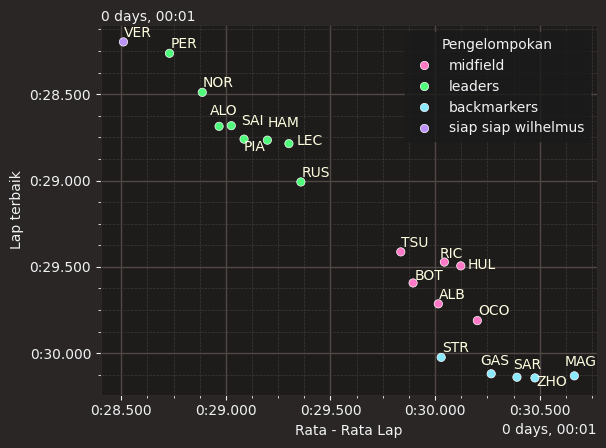

In [9]:
fig,ax=plt.subplots()
sns.scatterplot(data=avg_vs_min_Laptime,x='avgLap',y='bestLap',hue='Pengelompokan',zorder=10,ax=ax)
texts=[ax.annotate(row['Driver'],[row['avgLap'],row['bestLap']],zorder=10,color='lightyellow') for i,row in avg_vs_min_Laptime.iterrows()]

ylims=ax.get_ylim()
xlims=ax.get_xlim()
centre=(max(xlims)/2,max(ylims)/2)

ax.set_xlabel('Rata - Rata Lap')
ax.set_ylabel('Lap terbaik')
props=dict(boxstyle='round',facecolor='w',alpha=0.5)

adjust_text(texts)
colors = fastest_quali[['teamName','teamColor']].drop_duplicates().set_index('teamName').to_dict()['teamColor']
labels = list(colors.keys())[::-1]
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

In [14]:
fastest_quali.loc[:,'miniSect']=np.round(fastest_quali['RelativeDistance'].to_numpy()/(1/25))

speed_segments=fastest_quali[['Speed','miniSect','drvName','teamColor']]

dfSpeed=speed_segments.sort_values('Speed').drop_duplicates(subset='miniSect', keep='last').sort_values('miniSect').reset_index(drop=True)
listProp=dfSpeed[['drvName','teamColor']].value_counts(['drvName','teamColor'],normalize=True).reset_index()

single_lap = pd.DataFrame(japgp_q_2024.laps.pick_driver('PER').pick_fastest().get_telemetry())[['X','Y','RelativeDistance']]
single_lap['miniSect']=single_lap['RelativeDistance'].apply(lambda x: int(x/(1/25)))
single_lap=single_lap.merge(dfSpeed,on='miniSect')
single_lap=single_lap.merge(single_lap[['drvName']].drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index':'id'}),on='drvName')#id dari 0
single_lap['teamColor']=single_lap['drvName'].apply(lambda x:'#'+japgp_q_2024.get_driver(x).TeamColor)
single_lap=single_lap.merge(single_lap[['teamColor']].drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index':'idTeam'}),on='teamColor')#id dari 0
circuit_info = japgp_q_2024.get_circuit_info()

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.


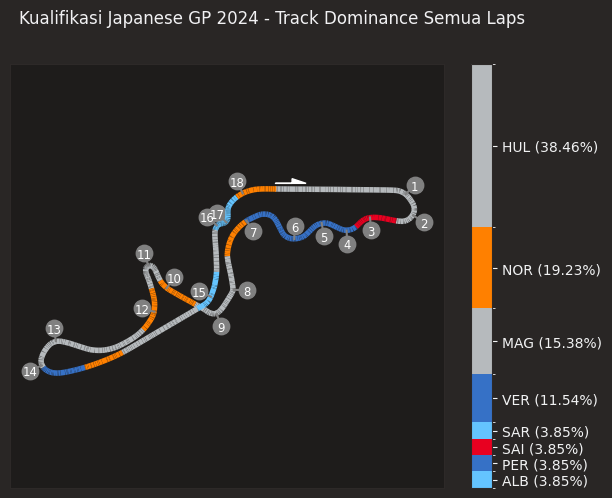

In [17]:
circRot=circuit_info.rotation
x,y=rotate_matrix(single_lap['X'].values,single_lap['Y'].values,circRot)


listProp.sort_values('proportion',inplace=True)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_avg=single_lap['idTeam'].to_numpy().astype(float)

#teamColor=single_lap[['id','tc']].drop_duplicates()
cmap = ListedColormap(single_lap['teamColor'].drop_duplicates().to_list())
lc_comp = LineCollection(segments, norm=plt.Normalize(0, cmap.N), cmap=cmap)
lc_comp.set_array(fastest_avg)
lc_comp.set_linewidth(4)


fig,ax=plt.subplots(figsize=(7,5.5))
    

fig.suptitle(
        f"Kualifikasi Japanese GP 2024 - Track Dominance Semua Laps"
    )
        
ax.add_collection(lc_comp)
ax.axis('equal')
ax.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

offset_vector = [700, 0] 
# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=math.radians(circRot))

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=math.radians(circRot))

    # Draw a circle next to the track.
    plt.scatter(text_x, text_y, color='grey', s=140)

    # Draw a line from the track to this circle.
    plt.plot([track_x, text_x], [track_y, text_y], color='grey')
    

    # Finally, print the corner number inside the circle.
    plt.text(text_x, text_y, txt,
             va='center_baseline', ha='center', size='small', color='white')
plt.arrow(x[0],y[0]+300,+900,0,color='white',shape='right',head_width=500)
bounds=[i*10 for i in(listProp.sort_values('proportion')['proportion'].to_list())]
bounds.insert(0,0)
boundsx=[]
mem=0
for i in bounds:
    i+=mem
    mem=i
    boundsx.append(i)


cmap = ListedColormap(listProp['teamColor'].to_list())
norm = BoundaryNorm(boundsx, cmap.N)

cbar=fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),ax=ax,spacing='proportional')
initial=0
ticksList=[]
for i in listProp['proportion']:
    if i!=0:
        ticksList.append((((i*10)/2)+initial))
        initial+=i*10

cbar.set_ticks(ticksList)
#listProp['bounds']=boundsx
labels=[]
for j,k in listProp.iterrows():
    label=f'{k["drvName"]} ({round(k["proportion"]*100,2)}%)'
    labels.append(label)

cbar.set_ticklabels(labels)#ambil driver name dari variabel!!!
plt.xticks([])
plt.yticks([])
plt.show()

In [5]:
drvLaps=japgp_q_2024.laps[['DriverNumber','LapNumber']].groupby('DriverNumber').max()
all_quali=pd.DataFrame()
for drv in japgp_q_2024.drivers:
    laps=japgp_q_2024.laps.pick_driver(drv)
    
    for i in range(1,int(drvLaps[drvLaps.index==drv]['LapNumber'].iloc[0])):
        try:
            df_temp=pd.DataFrame(laps.pick_lap(i).pick_accurate().pick_wo_box().get_telemetry())
            df_temp['drvName']=japgp_q_2024.get_driver(drv).Abbreviation
            df_temp['teamName']=japgp_q_2024.get_driver(drv).TeamName
            df_temp['teamColor']='#'+japgp_q_2024.get_driver(drv).TeamColor
            df_temp['LapNumber']=i
            all_quali=pd.concat([all_quali,df_temp])
        except:
            continue
all_quali['miniSect']=(np.round(all_quali['RelativeDistance'].to_numpy()/(1/2))+1).astype(int)

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core      

In [16]:
first_set=all_quali[['drvName','Time','miniSect','LapNumber','teamColor','teamName']].groupby(['drvName','miniSect','LapNumber','teamColor','teamName']).agg(getDuration).reset_index()
theoretical_best_minisectors=first_set[['drvName','Time','miniSect','teamColor','teamName']].groupby(['drvName','miniSect','teamColor','teamName']).min().reset_index()
sum_tbest_minisectors=theoretical_best_minisectors.groupby(['drvName','teamColor','teamName']).agg(IdealmSTime=('Time','sum')).reset_index()


allLaps=pd.DataFrame(japgp_q_2024.laps.pick_accurate().pick_wo_box()[['Driver','DriverNumber','LapTime','Sector1Time','Sector2Time','Sector3Time','Compound','Team']])

fast_agg=allLaps[['Driver','DriverNumber','LapTime','Sector1Time','Sector2Time','Sector3Time','Team']].groupby(['Driver','DriverNumber','Team']).agg(BestLap=('LapTime','min'),BestS1=('Sector1Time','min'),BestS2=('Sector2Time','min'),BestS3=('Sector3Time','min'))

fast_agg['TheoreticalBest']=fast_agg['BestS1']+fast_agg['BestS2']+fast_agg['BestS3']
fast_agg.reset_index(inplace=True)
fast_agg=fast_agg.merge(sum_tbest_minisectors, left_on='Driver', right_on='drvName')
fast_agg.sort_values(by='BestLap',inplace=True)

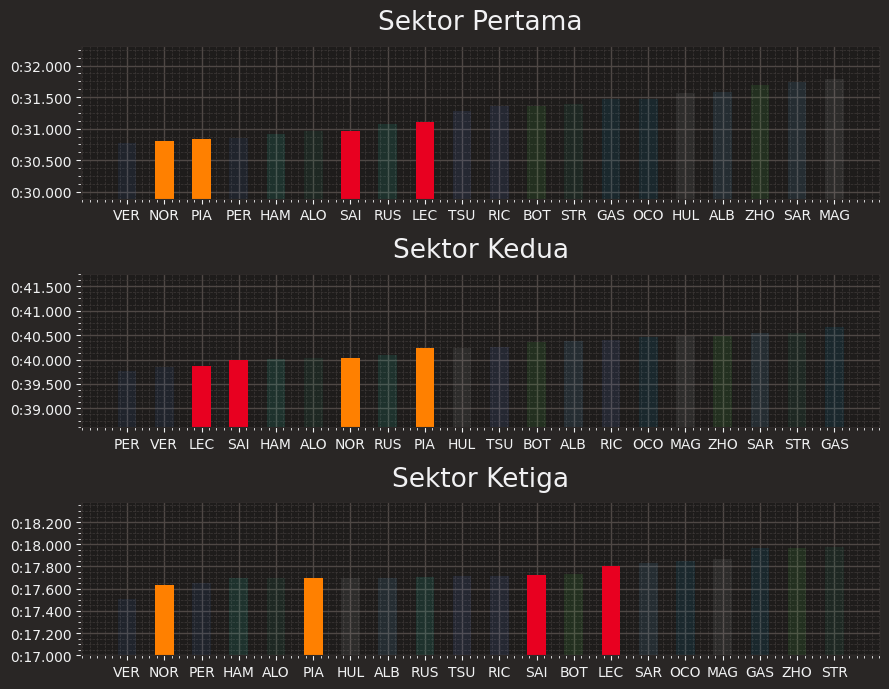

In [17]:
fig,ax=plt.subplots(3,1,figsize=(9,7))
fast_agg.sort_values('BestS1',inplace=True)
for i,row in fast_agg.iterrows():
    if row['Team'] in ['Ferrari','McLaren']:
        alphaVar=1
    else:
        alphaVar=0.1
    #bottom=np.zeros(len(fast_agg)).astype('<m8[ns]')
    ax[0].bar(x=row['Driver'],height=row['BestS1'],width=0.5,color=row['teamColor'],alpha=alphaVar)
    #bottom+=row['BestS1'].to_numpy()
    y1,y2=ax[0].get_ylim()
    y1=y2*0.925
    #y2=y2*0.955
    ax[0].set_ylim(y1,y2)
fast_agg.sort_values('BestS2',inplace=True)
for i,row in fast_agg.iterrows():
    if row['Team'] in ['Ferrari','McLaren']:
        alphaVar=1
    else:
        alphaVar=0.1
    ax[1].bar(x=row['Driver'],height=row['BestS2'],width=0.5,color=row['teamColor'],alpha=alphaVar)
    #bottom+=row['BestS2'].to_numpy()
    y1,y2=ax[1].get_ylim()
    y1=y2*0.925
    #y2=y2*0.955
    ax[1].set_ylim(y1,y2)
fast_agg.sort_values('BestS3',inplace=True)
for i,row in fast_agg.iterrows():
    if row['Team'] in ['Ferrari','McLaren']:
        alphaVar=1
    else:
        alphaVar=0.1
    ax[2].bar(x=row['Driver'],height=row['BestS3'],width=0.5,color=row['teamColor'],alpha=alphaVar)
    y1,y2=ax[2].get_ylim()
    y1=y2*0.925
    #y2=y2*0.955
    ax[2].set_ylim(y1,y2)
ax[0].set_title('Sektor Pertama')
ax[1].set_title('Sektor Kedua')
ax[2].set_title('Sektor Ketiga')
colors = fast_agg[['teamName','teamColor']].drop_duplicates().set_index('teamName').to_dict()['teamColor']
labels = list(colors.keys())[::-1]
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
#fig.legend(handles, labels)
fig.tight_layout()
plt.show()

<H1>Analisis Balapan</H1>

In [4]:
japgp24_race=fastf1.get_session(2024,'japan','r')
japgp24_race.load()

req         WARNING 	DEFAULT CACHE ENABLED! (238.55 MB) C:\Users\haryo\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.3.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching tr

In [5]:
laps_corrected=pd.DataFrame()
for drv in japgp24_race.drivers:
    df=(japgp24_race.laps.pick_driver(drv)['LapNumber']-1)*(101/japgp24_race.total_laps)*35

    df[:]=df[::-1]
    df=df.apply(lambda x: timedelta(milliseconds=x))


    laps=pd.DataFrame(japgp24_race.laps.pick_driver(drv))
    laps['fuel_corrected_laptime']=(laps['LapTime'])-df
    
    laps_corrected=pd.concat([laps_corrected,laps])

C:\Users\haryo\AppData\Local\Temp\ipykernel_28400\2000430164.py:8: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  tyreAlphas=pd.concat([tyreAlphas,(alphas-(alphas.min()-2))/(alphas.max()-(alphas.min()-2))])


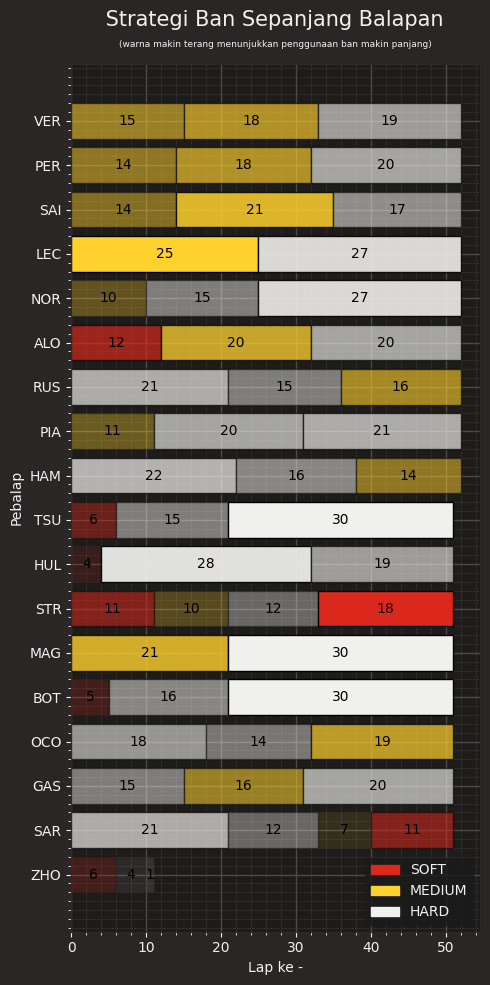

In [6]:
japgp_tyre=laps_corrected[['Driver','DriverNumber','LapNumber','Compound','TyreLife','Stint','FreshTyre']]
japgp_tyre=japgp_tyre.drop(japgp_tyre[japgp_tyre['LapNumber']<2].index)
japgp_tyre=japgp_tyre.groupby(['Driver','DriverNumber','Compound','Stint','FreshTyre']).agg({'LapNumber':'count','TyreLife':'max'}).sort_values(by=['Driver','DriverNumber','Stint']).reset_index()
tyregroup=japgp_tyre[['Driver','Compound','TyreLife']].groupby('Compound')
tyreAlphas=pd.Series()
for i,group in tyregroup:
    alphas=group['TyreLife']
    tyreAlphas=pd.concat([tyreAlphas,(alphas-(alphas.min()-2))/(alphas.max()-(alphas.min()-2))])
japgp_tyre=japgp_tyre.merge(pd.DataFrame(tyreAlphas),left_index=True,right_index=True).rename(columns={0:'alpha'})
fig,ax=plt.subplots(figsize=(5,10))
for driver in japgp24_race.drivers:
    driver_stints = japgp_tyre.loc[japgp_tyre["DriverNumber"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        # each row contains the compound name and stint length
        # we can use these information to draw horizontal bars

        bars=ax.barh(
            y=row['Driver'],
            width=row["LapNumber"],
            left=previous_stint_end,
            color=fastf1.plotting.COMPOUND_COLORS[row["Compound"]],
            edgecolor="black",
            fill=True,
            label=row['Compound'],
            alpha=row['alpha']
        )
        
        ax.bar_label(bars, label_type='center', color='black')
        
        previous_stint_end += row["LapNumber"]

ax.invert_yaxis()
tyres=pd.DataFrame(fastf1.plotting.COMPOUND_COLORS,index=[0]).T.reset_index(names='Compound')
tyresLegend=tyres[tyres['Compound'].isin(japgp_tyre['Compound'])]
colors = tyresLegend.set_index('Compound').to_dict()[0]
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax.legend(handles, labels)

ax.set_xlabel('Lap ke -')
ax.set_ylabel('Pebalap')

fig.suptitle('         Strategi Ban Sepanjang Balapan',fontsize=15)
ax.set_title('(warna makin terang menunjukkan penggunaan ban makin panjang)',fontsize=6.5)
fig.tight_layout()
#fig.legend(driver_stints['Compound'].unique())
plt.show()

C:\Users\haryo\AppData\Local\Temp\ipykernel_28400\2437362589.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pits=japgp24_race.laps.pick_drivers(['NOR','LEC','VER','ALO','RUS','PER','SAI','PIA','HAM']).dropna(subset='PitInTime')[japgp24_race.laps['LapNumber']>1][['Driver','DriverNumber','LapNumber','Team']]


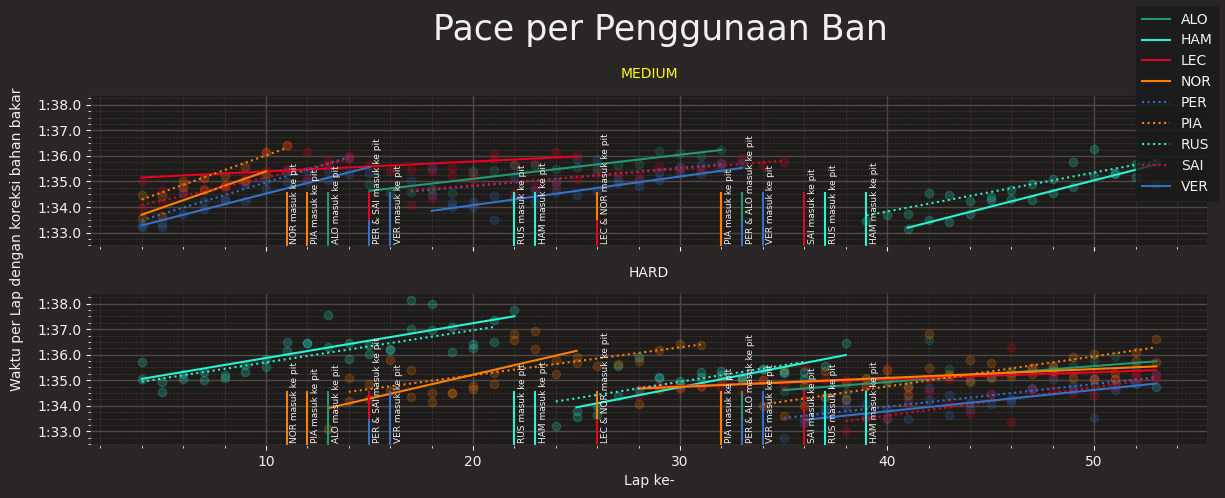

In [7]:
import datetime
pits=japgp24_race.laps.pick_drivers(['NOR','LEC','VER','ALO','RUS','PER','SAI','PIA','HAM']).dropna(subset='PitInTime')[japgp24_race.laps['LapNumber']>1][['Driver','DriverNumber','LapNumber','Team']]

fig,ax=plt.subplots(2,1,sharey=True,sharex=True,figsize=(12,5))
for i,row in laps_corrected[(laps_corrected['LapNumber']>1) & (laps_corrected['IsAccurate']==True) &(laps_corrected['LapTime']<timedelta(minutes=2,seconds=0)) & (laps_corrected['Driver'].isin(['NOR','LEC','VER','ALO','RUS','PER','SAI','PIA','HAM']))].iterrows():
    if row['Compound']=='MEDIUM':
        ax[0].scatter(row['LapNumber'],row['fuel_corrected_laptime'],color='#'+japgp24_race.get_driver(row['DriverNumber']).TeamColor,alpha=0.2)
    if row['Compound']=='HARD':
        ax[1].scatter(row['LapNumber'],row['fuel_corrected_laptime'],color='#'+japgp24_race.get_driver(row['DriverNumber']).TeamColor,alpha=0.2)
ax[0].set_title('MEDIUM',color='yellow',fontsize=10)
ax[1].set_xlabel('Lap ke-')
fig.text(-.01,0.23,'Waktu per Lap dengan koreksi bahan bakar',rotation=90)
ax[1].set_title('HARD',fontsize=10)
dfTeamNum=pd.DataFrame(laps_corrected)[['Driver','Team','DriverNumber']].drop_duplicates().set_index('Driver').groupby('Team').rank().reset_index()
laps_corrected_plus=dfTeamNum.rename(columns={'DriverNumber':'TeamNum'}).merge(laps_corrected, on='Driver')
stintgroups=laps_corrected_plus[(laps_corrected_plus['LapNumber']>1) & (laps_corrected_plus['IsAccurate']==True) &(laps_corrected_plus['LapTime']<timedelta(minutes=2,seconds=0)) & (laps_corrected_plus['Driver'].isin(['NOR','LEC','VER','ALO','RUS','PER','SAI','PIA','HAM']))][['Stint','Compound','fuel_corrected_laptime','LapNumber','Driver','Team','TeamNum']].groupby(['Compound','Driver','Stint','Team','TeamNum'])
drvCache=[]
for i,group in stintgroups:
    if i[1] in drvCache:
        labelVar=''
    else:
        labelVar=i[1]
        drvCache.append(i[1])
    if i[4]==1:
        linestyleVar='-'
    else:
        linestyleVar=':'
   # xx = np.linspace(min(group['fuel_corrected_laptime']),max(group['fuel_corrected_laptime']), 100)
    y = group['fuel_corrected_laptime'].apply(lambda x: x.total_seconds())
    a, b = np.polyfit(group['LapNumber'],y, 1)
    
    if i[0]=='MEDIUM':
        ax[0].plot(group['LapNumber'], pd.Series(a*group['LapNumber']+b).apply(lambda x: datetime.timedelta(seconds=x)),color='#'+japgp24_race.get_driver(i[1]).TeamColor,linestyle=linestyleVar,label=labelVar)
    if i[0]=='HARD':
        ax[1].plot(group['LapNumber'], pd.Series(a*group['LapNumber']+b).apply(lambda x: datetime.timedelta(seconds=x)),color='#'+japgp24_race.get_driver(i[1]).TeamColor,linestyle=linestyleVar,label=labelVar)
pits_grouped=pits.groupby('LapNumber')
for ax in ax:

    for i,group in pits_grouped:
        
        group.reset_index(inplace=True)
        if len(group['Driver'])==2:
            ax.axvline(x=group['LapNumber'][0],color='#'+japgp24_race.get_driver(group['DriverNumber'][0]).TeamColor,ymax=0.35/2)
            ax.axvline(x=group['LapNumber'][0],color='#'+japgp24_race.get_driver(group['DriverNumber'][1]).TeamColor,ymin=0.35/2,ymax=0.35)
            ax.text(group['LapNumber'][0]+0.17, 0.001071, f"{group['Driver'][0]} & {group['Driver'][1]} masuk ke pit", rotation=90, verticalalignment='bottom',fontsize=6.5)
        else:
            for i,row in group.iterrows():
                ax.axvline(x=row['LapNumber'],color='#'+japgp24_race.get_driver(row['DriverNumber']).TeamColor,ymax=0.35)
                ax.text(row['LapNumber']+0.17, 0.001071, f"{row['Driver']} masuk ke pit", rotation=90, verticalalignment='bottom',fontsize=6.5)
fig.suptitle('       Pace per Penggunaan Ban',fontsize=25)

fig.tight_layout()
fig.legend()

plt.show()

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core      

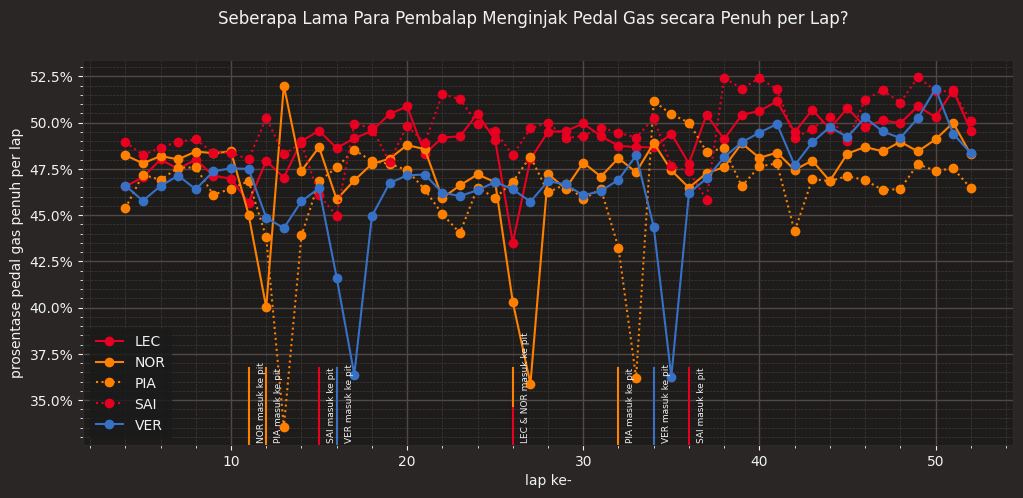

In [8]:
lap=[]
drivers=[]
throttleDuration=[]
for driver in japgp24_race.drivers:
    
    for laps in range(2,japgp24_race.total_laps):
        drivers.append(japgp24_race.get_driver(driver).Abbreviation)
        lap.append(laps)
        try:
            test=pd.DataFrame(japgp24_race.laps.pick_driver(driver).pick_lap(laps).get_telemetry())[['Throttle','Time']]
        except:
            throttleDuration.append(None)
            continue
        
        index=0
        isFullThrottle=[]
        for i,row in test.iterrows():
            if i==2 and row['Throttle']>=98:
                index+=1
                isFullThrottle.append(index)
            elif row['Throttle']>=98 and test['Throttle'][i-1]<98:
                index+=1
                isFullThrottle.append(index)
            elif row['Throttle']>=98:
                isFullThrottle.append(index)
            else:
                isFullThrottle.append(None)
        test['fullThrottleIndex']=isFullThrottle
        test_group=test.groupby('fullThrottleIndex')
        total_time=datetime.timedelta()
        for i,group in test_group:
            total_time+=getDuration(group['Time'])
        throttleDuration.append(total_time)
test_dic=zip(lap,drivers,throttleDuration)  

dfThrottle=pd.DataFrame(list(test_dic)).rename(columns={0:'LapNumber',1:'Driver',2:'FullThrottleDuration'})

dfThrottle['tc']=dfThrottle['Driver'].apply(lambda x: '#'+japgp24_race.get_driver(x).TeamColor)

dfThrottle=dfThrottle.merge(japgp24_race.laps[['LapTime','LapNumber','Driver']], on=['LapNumber','Driver']).dropna()
dfThrottle['PercentFullThrottle']=(dfThrottle['FullThrottleDuration']/dfThrottle['LapTime'])*100

fig,ax=plt.subplots(figsize=(12,5))
#sns.lineplot(data=dfThrottle,x='LapNumber',y='FullThrottleDuration',hue='Driver',ax=ax,marker='o')
pits=japgp24_race.laps.pick_drivers(['NOR','LEC','SAI','PIA','VER']).dropna(subset='PitInTime')[japgp24_race.laps['LapNumber']>1][['Driver','DriverNumber','LapNumber']]
tcCache=[]
dfThrottleViz=dfThrottle[(dfThrottle['LapNumber']>=4) & (dfThrottle['Driver'].isin(['NOR','LEC','SAI','PIA','VER']))]
for i,group in dfThrottleViz.groupby(['Driver','tc']):
    if i[1] in tcCache:
        linestyleVar=':'
    else:
        linestyleVar='-'
    tcCache.append(i[1])
    ax.plot(group['LapNumber'],group['PercentFullThrottle'],color=i[1],label=i[0],marker='o',linestyle=linestyleVar)
    pits_grouped=pits.groupby('LapNumber')

for i,group in pits_grouped:
    group.reset_index(inplace=True)
    if len(group['Driver'])==2:
        ax.axvline(x=group['LapNumber'][0],color='#'+japgp24_race.get_driver(group['DriverNumber'][0]).TeamColor,ymax=0.2/2)
        ax.axvline(x=group['LapNumber'][0],color='#'+japgp24_race.get_driver(group['DriverNumber'][1]).TeamColor,ymin=0.2/2,ymax=0.2)
        ax.text(group['LapNumber'][0]+0.45, 32.7, f"{group['Driver'][0]} & {group['Driver'][1]} masuk ke pit", rotation=90, verticalalignment='bottom',fontsize=6.5)
    else:
        for i,row in group.iterrows():
            ax.axvline(x=row['LapNumber'],color='#'+japgp24_race.get_driver(row['DriverNumber']).TeamColor,ymax=0.2)
            ax.text(row['LapNumber']+0.45, 32.7, f"{row['Driver']} masuk ke pit", rotation=90, verticalalignment='bottom',fontsize=6.5)
from matplotlib.ticker import PercentFormatter
fig.suptitle('Seberapa Lama Para Pembalap Menginjak Pedal Gas secara Penuh per Lap?')
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_ylabel('prosentase pedal gas penuh per lap')
ax.set_xlabel('lap ke-')

ax.legend()

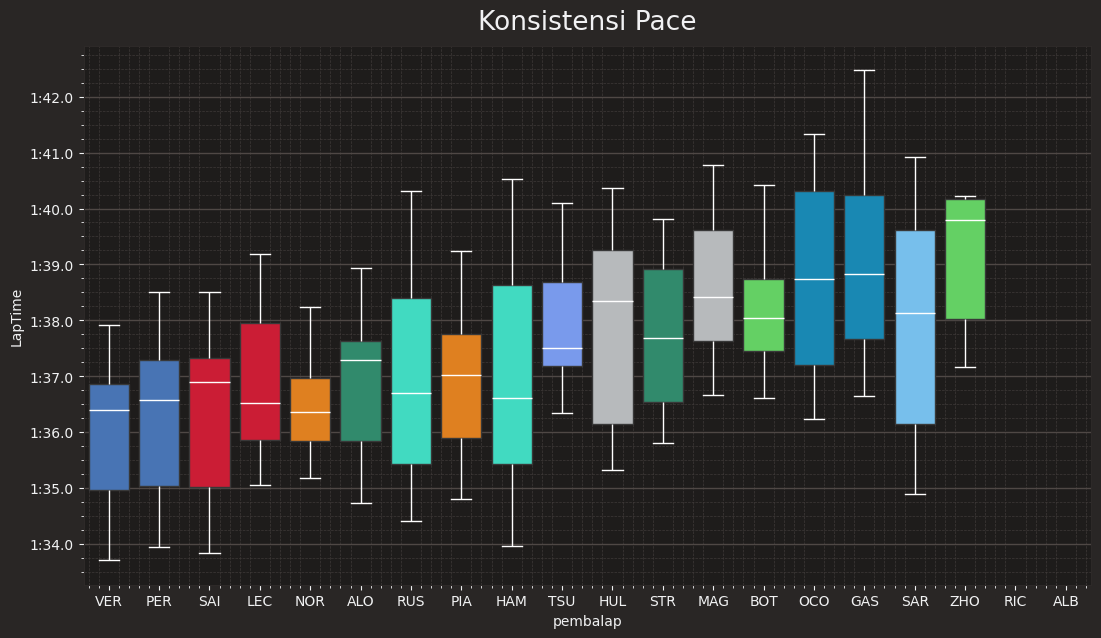

In [9]:

teamsColor={row['Team']:'#'+japgp24_race.get_driver(row['Driver']).TeamColor for i,row in pd.DataFrame(japgp24_race.laps[['Team','Driver']]).iterrows()} 

fig,axs=plt.subplots(figsize=(13,7))
sns.boxplot(data=japgp24_race.laps.pick_wo_box(),x='Driver',y='LapTime',hue='Team',legend=False,palette=teamsColor,ax=axs,showfliers=False)
lines=axs.lines
for i in lines:
    i.set_color('w')
axs.set_title('Konsistensi Pace')
axs.set_xlabel('pembalap')
axs.invert_yaxis()

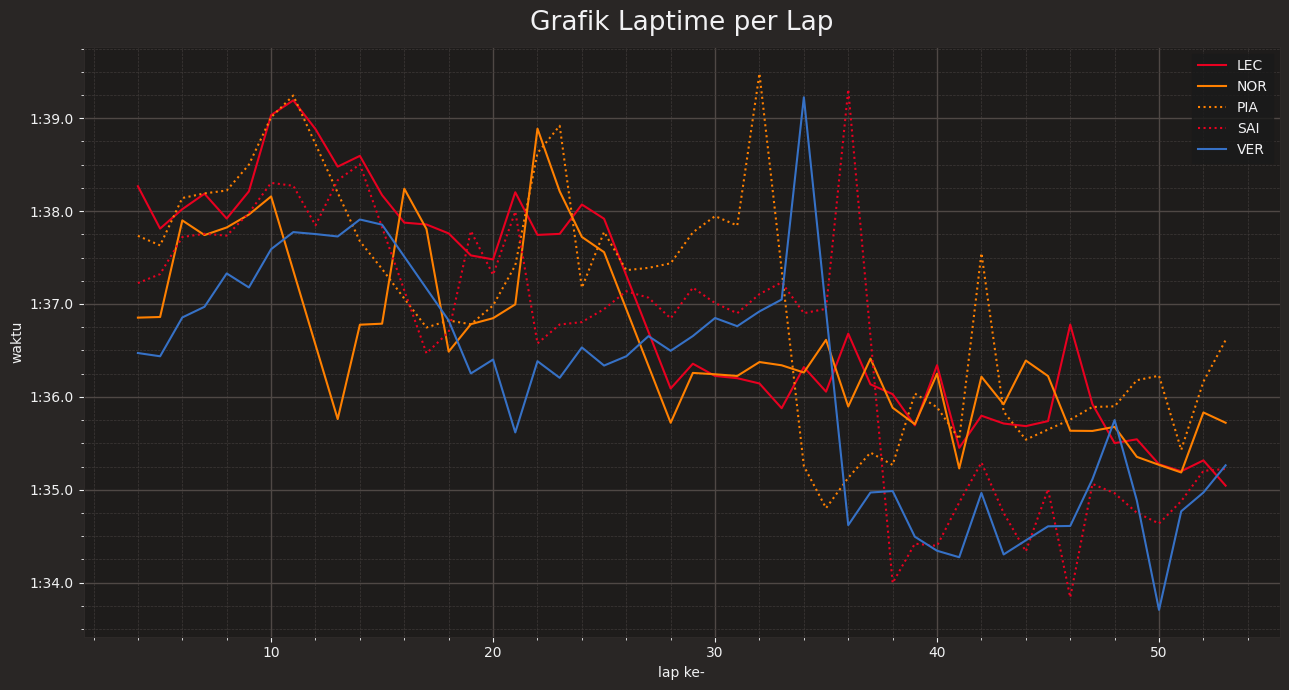

In [11]:
from scipy.interpolate import make_interp_spline
laps_corrected_lim=laps_corrected[laps_corrected['LapTime']<datetime.timedelta(minutes=1,seconds=40)]
fig,axs=plt.subplots(figsize=(13,7))
cacheTeam=[]
for index,group in laps_corrected_lim[laps_corrected_lim['Driver'].isin(['NOR','VER','LEC','SAI','PIA'])][['LapTime','LapNumber','Driver','DriverNumber','Team']].groupby(['Driver','DriverNumber','Team']):
    if index[2] in cacheTeam:
        linestyleVar=':'
    else:
        linestyleVar='-'
        cacheTeam.append(index[2])
    
    X_Y_Spline = make_interp_spline(group['LapNumber'], group['LapTime'])
    X_ = np.linspace(group['LapNumber'].min(), group['LapNumber'].max(), 500)
    Y_ = X_Y_Spline(X_)
    axs.plot(group['LapNumber'], group['LapTime'],color='#'+japgp24_race.get_driver(index[1]).TeamColor,linestyle=linestyleVar,label=index[0])
#sns.lineplot(data=laps_corrected_lim[laps_corrected_lim['LapNumber']>3],y='LapTime',x='LapNumber',hue='Driver',ax=axs[1],palette=teamsColor)
#axs[1].set_ylim(0.00107,0.00116)
#fig.suptitle('Konsistensi Pace')

axs.set_title('Grafik Laptime per Lap')
axs.set_ylabel('waktu')

axs.set_ylabel('waktu')
axs.set_xlabel('lap ke-')

axs.legend()
fig.tight_layout()

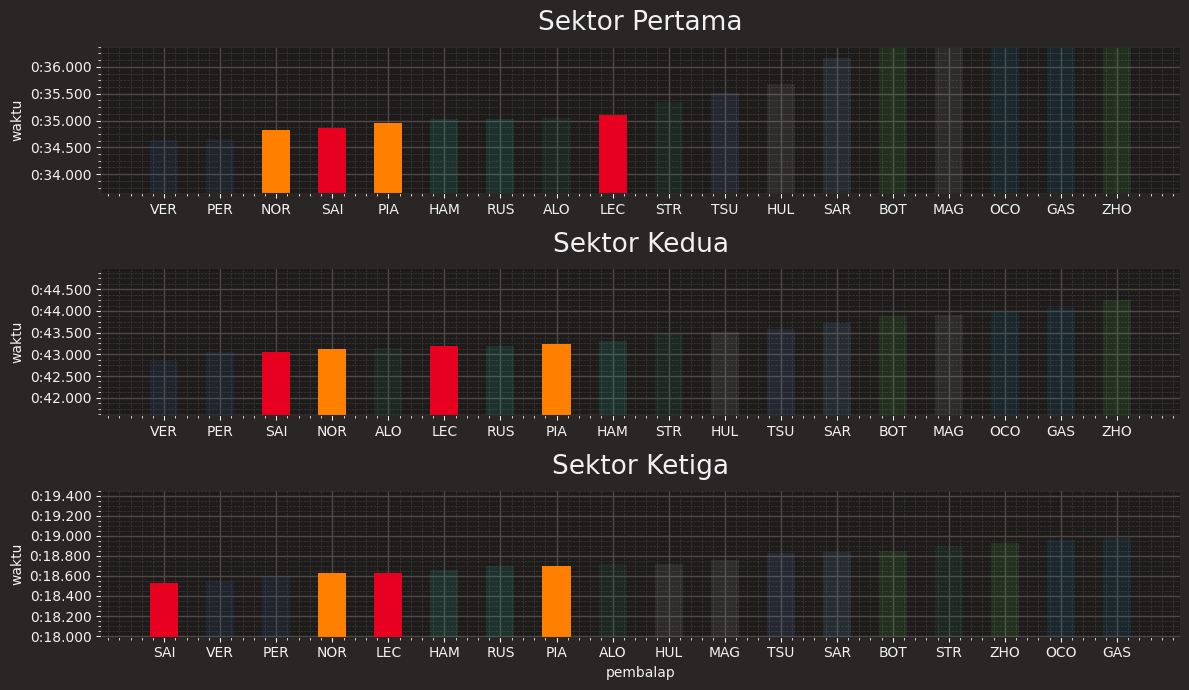

In [12]:
fig,axs=plt.subplots(3,1,figsize=(12,7))
dfSectors=japgp24_race.laps.pick_accurate().pick_wo_box()[['Driver','Sector1Time','Sector2Time','Sector3Time','Team']].groupby(['Driver','Team']).mean().reset_index()
dfSectors['teamColors']=dfSectors['Driver'].apply(lambda x: '#'+japgp24_race.get_driver(x).TeamColor)
dfSectors.sort_values('Sector1Time',inplace=True)
for i,row in dfSectors.iterrows():
    if row['Team'] in ['Ferrari','McLaren']:
        alphaVar=1
    else:
        alphaVar=0.1
    axs[0].bar(x=row['Driver'],height=row['Sector1Time'],width=0.5,color=row['teamColors'],alpha=alphaVar)
    #bottom+=row['BestS1'].to_numpy()
    y1,y2=axs[0].get_ylim()
    y1=y2*0.925
    #y2=y2*0.955
    axs[0].set_ylim(y1,y2)
dfSectors.sort_values('Sector2Time',inplace=True)
for i,row in dfSectors.iterrows():
    if row['Team'] in ['Ferrari','McLaren']:
        alphaVar=1
    else:
        alphaVar=0.1
    axs[1].bar(x=row['Driver'],height=row['Sector2Time'],width=0.5,color=row['teamColors'],alpha=alphaVar)
    #bottom+=row['BestS1'].to_numpy()
    y1,y2=axs[1].get_ylim()
    y1=y2*0.925
    #y2=y2*0.955
    axs[1].set_ylim(y1,y2)
dfSectors.sort_values('Sector3Time',inplace=True)
for i,row in dfSectors.iterrows():
    if row['Team'] in ['Ferrari','McLaren']:
        alphaVar=1
    else:
        alphaVar=0.1
    axs[2].bar(x=row['Driver'],height=row['Sector3Time'],width=0.5,color=row['teamColors'],alpha=alphaVar)
    #bottom+=row['BestS1'].to_numpy()
    y1,y2=axs[2].get_ylim()
    y1=y2*0.925
    #y2=y2*0.955
    axs[2].set_ylim(y1,y2)
axs[1].set_ylabel('waktu')
axs[0].set_ylabel('waktu')
axs[2].set_ylabel('waktu')
axs[0].set_title('Sektor Pertama')
axs[1].set_title('Sektor Kedua')
axs[2].set_title('Sektor Ketiga')
axs[2].set_xlabel('pembalap')
fig.tight_layout()

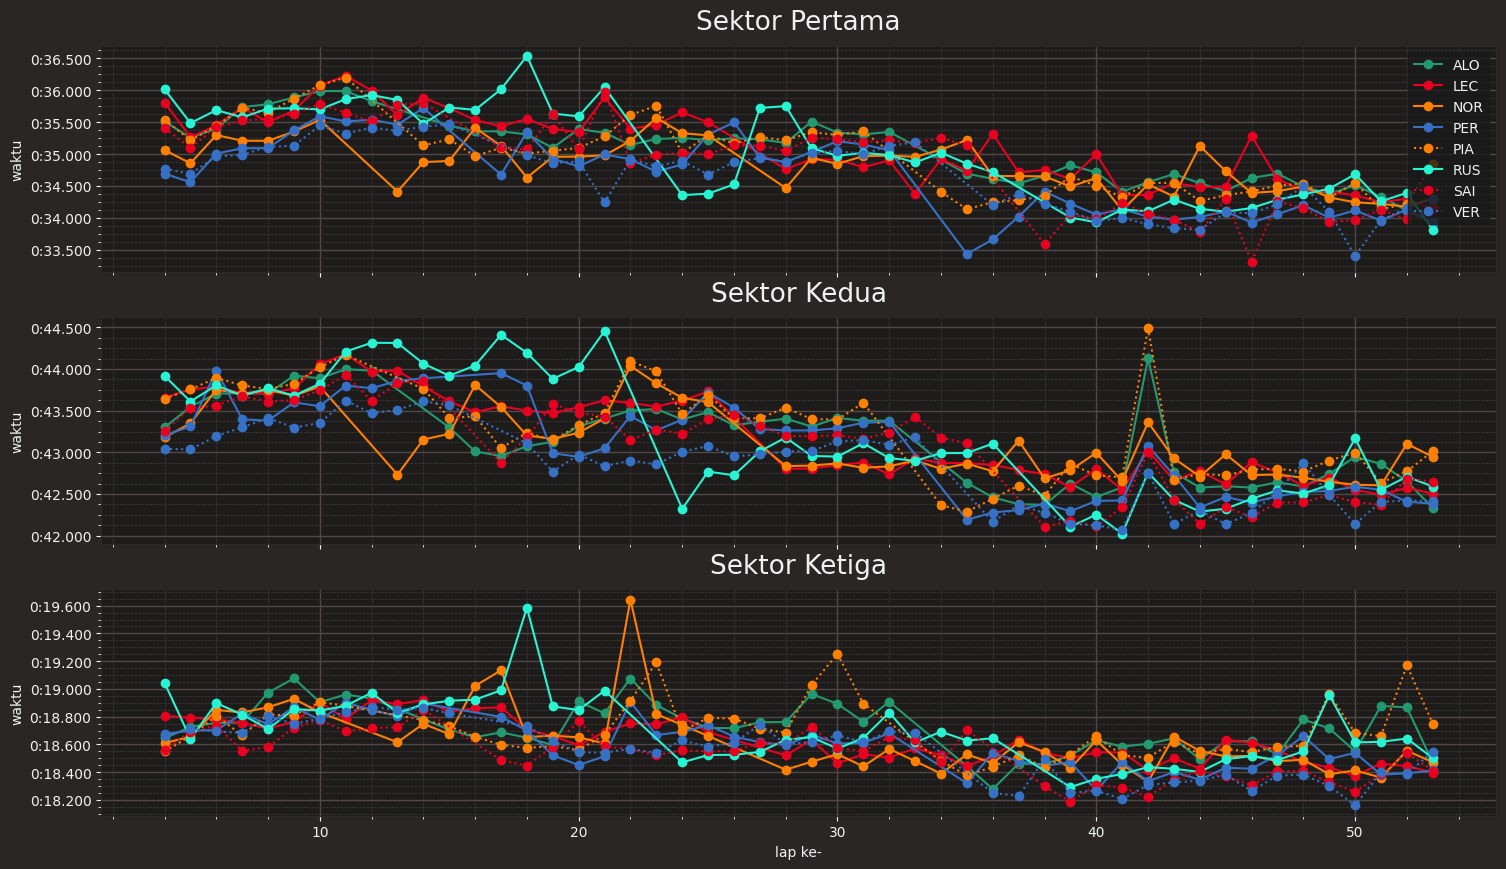

In [13]:
ranks=pd.DataFrame()
for Lap,group in pd.DataFrame(japgp24_race.laps.pick_accurate().pick_wo_box()[['Driver','LapNumber','Sector1Time','Sector2Time','Sector3Time','Team']]).groupby('LapNumber'):
    group['LapNumber']=Lap
    group.set_index(['LapNumber','Driver','Team'],inplace=True)
    ranks=pd.concat([ranks,group.rank(method='dense')])
ranks=ranks.reset_index()

fig,axs=plt.subplots(3,1,figsize=(18,10),sharex=True)
teamCache=[]
for i,group in japgp24_race.laps.pick_accurate().pick_wo_box()[['Driver','LapNumber','Sector1Time','Sector2Time','Sector3Time','Team']].groupby(['Driver','Team']):
    if i[0] not in ['VER','PER','SAI','LEC','PIA','NOR','ALO','RUS']:
        continue
    if i[1] in teamCache:
        linestyleVar=':'
    else:
        linestyleVar='-'
        teamCache.append(i[1])
    axs[0].plot(group['LapNumber'],group['Sector1Time'],marker='o',linestyle=linestyleVar,color='#'+japgp24_race.get_driver(i[0]).TeamColor,label=i[0])
    
teamCache=[]
for i,group in japgp24_race.laps.pick_accurate().pick_wo_box()[['Driver','LapNumber','Sector1Time','Sector2Time','Sector3Time','Team']].groupby(['Driver','Team']):
    if i[0] not in ['VER','PER','SAI','LEC','PIA','NOR','ALO','RUS']:
        continue
    if i[1] in teamCache:
        linestyleVar=':'
    else:
        linestyleVar='-'
        teamCache.append(i[1])
    axs[1].plot(group['LapNumber'],group['Sector2Time'],marker='o',linestyle=linestyleVar,color='#'+japgp24_race.get_driver(i[0]).TeamColor,label=i[0])
    
teamCache=[]
for i,group in japgp24_race.laps.pick_accurate().pick_wo_box()[['Driver','LapNumber','Sector1Time','Sector2Time','Sector3Time','Team']].groupby(['Driver','Team']):
    if i[0] not in ['VER','PER','SAI','LEC','PIA','NOR','ALO','RUS']:
        continue
    if i[1] in teamCache:
        linestyleVar=':'
    else:
        linestyleVar='-'
        teamCache.append(i[1])
    axs[2].plot(group['LapNumber'],group['Sector3Time'],marker='o',linestyle=linestyleVar,color='#'+japgp24_race.get_driver(i[0]).TeamColor,label=i[0])
axs[1].set_ylabel('waktu')
axs[0].set_ylabel('waktu')
axs[2].set_ylabel('waktu')
axs[0].set_title('Sektor Pertama')
axs[1].set_title('Sektor Kedua')
axs[2].set_title('Sektor Ketiga')
axs[2].set_xlabel('lap ke-')
axs[0].legend()

In [14]:
race_telem=pd.DataFrame()
for drv in japgp24_race.drivers:
    try:
        tmp_df=pd.DataFrame(japgp24_race.laps.pick_driver(drv).pick_fastest().get_telemetry())
    except:
        continue
    tmp_df['drvNum']=float(japgp24_race.get_driver(drv).DriverNumber)
    tmp_df['tc']='#'+japgp24_race.get_driver(drv).TeamColor
    tmp_df['drv']=japgp24_race.get_driver(drv).Abbreviation
    race_telem=pd.concat([race_telem,tmp_df])

#race_telem=race_telem.query("DRS in [0,1,2,3,8]")

race_telem.loc[:,'miniSect']=np.round(race_telem['RelativeDistance'].to_numpy()/(1/20))+1

race_speed=race_telem[['Speed','miniSect','drv','drvNum','tc']]

dfSpeed=race_speed.sort_values('Speed').drop_duplicates(subset='miniSect', keep='last').sort_values('miniSect').reset_index(drop=True)
listProp=dfSpeed[['drv','tc']].value_counts(['drv','tc'],normalize=True).reset_index()

single_lap = pd.DataFrame(japgp24_race.laps.pick_driver('PER').pick_fastest().get_telemetry())[['X','Y','RelativeDistance']]
single_lap['miniSect']=single_lap['RelativeDistance'].apply(lambda x: int(x/(1/20))+1)
single_lap=single_lap.merge(dfSpeed,on='miniSect')
single_lap=single_lap.merge(single_lap[['drv']].drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index':'id'}),on='drv')#id dari 0
single_lap['tc']=single_lap['drv'].apply(lambda x:'#'+japgp24_race.get_driver(x).TeamColor)
single_lap=single_lap.merge(single_lap[['tc']].drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index':'idTeam'}),on='tc')#id dari 0

circuit_info = japgp24_race.get_circuit_info()

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core      

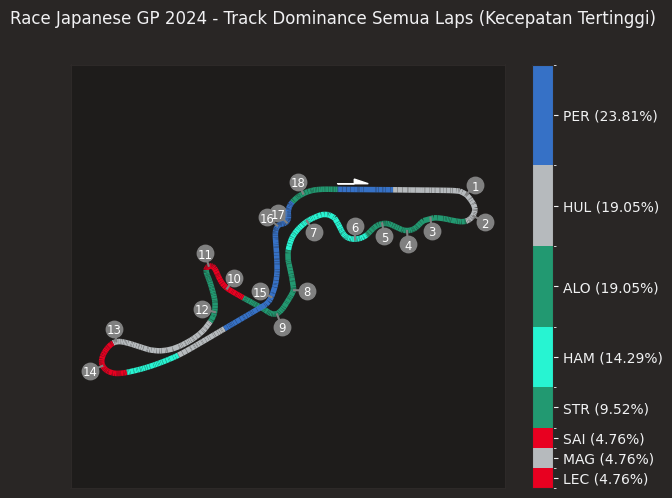

In [15]:
from matplotlib.colors import BoundaryNorm, ListedColormap
circRot=circuit_info.rotation
x,y=rotate_matrix(single_lap['X'].values,single_lap['Y'].values,circRot)


listProp.sort_values('proportion',inplace=True)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_avg=single_lap['idTeam'].to_numpy().astype(float)

#teamColor=single_lap[['id','tc']].drop_duplicates()
cmap = ListedColormap(single_lap['tc'].drop_duplicates().to_list())
lc_comp = LineCollection(segments, norm=plt.Normalize(0, cmap.N), cmap=cmap)
lc_comp.set_array(fastest_avg)
lc_comp.set_linewidth(4)


fig,ax=plt.subplots(figsize=(7,5.5))
    

fig.suptitle(
        f"Race Japanese GP 2024 - Track Dominance Semua Laps (Kecepatan Tertinggi)"
    )
        
ax.add_collection(lc_comp)
ax.axis('equal')
ax.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

offset_vector = [700, 0] 
# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=math.radians(circRot))

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=math.radians(circRot))

    # Draw a circle next to the track.
    plt.scatter(text_x, text_y, color='grey', s=140)

    # Draw a line from the track to this circle.
    plt.plot([track_x, text_x], [track_y, text_y], color='grey')
    

    # Finally, print the corner number inside the circle.
    plt.text(text_x, text_y, txt,
             va='center_baseline', ha='center', size='small', color='white')
plt.arrow(x[0],y[0]+300,+900,0,color='white',shape='right',head_width=500)
bounds=[i*10 for i in(listProp.sort_values('proportion')['proportion'].to_list())]
bounds.insert(0,0)
boundsx=[]
mem=0
for i in bounds:
    i+=mem
    mem=i
    boundsx.append(i)


cmap = ListedColormap(listProp['tc'].to_list())
norm = BoundaryNorm(boundsx, cmap.N)

cbar=fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),ax=ax,spacing='proportional')
initial=0
ticksList=[]
for i in listProp['proportion']:
    if i!=0:
        ticksList.append((((i*10)/2)+initial))
        initial+=i*10

cbar.set_ticks(ticksList)
#listProp['bounds']=boundsx
labels=[]
for j,k in listProp.iterrows():
    label=f'{k["drv"]} ({round(k["proportion"]*100,2)}%)'
    labels.append(label)

cbar.set_ticklabels(labels)#ambil driver name dari variabel!!!
plt.xticks([])
plt.yticks([])
plt.show()

In [16]:
drvLaps=japgp24_race.laps[['DriverNumber','LapNumber']].groupby('DriverNumber').max()
all_race=pd.DataFrame()
for drv in japgp24_race.drivers:
    laps=japgp24_race.laps.pick_driver(drv)
    
    for i in range(1,int(drvLaps[drvLaps.index==drv]['LapNumber'].iloc[0])):
        try:
            df_temp=pd.DataFrame(laps.pick_lap(i).pick_accurate().pick_wo_box().get_telemetry())
            df_temp['drvName']=japgp24_race.get_driver(drv).Abbreviation
            df_temp['teamName']=japgp24_race.get_driver(drv).TeamName
            df_temp['teamColor']='#'+japgp24_race.get_driver(drv).TeamColor
            df_temp['LapNumber']=i
            all_race=pd.concat([all_race,df_temp])
        except:
            continue

all_race['miniSect']=(np.round(all_race['RelativeDistance'].to_numpy()/(1/20))+1).astype(int)
first_set=all_race[['drvName','Time','miniSect','LapNumber','teamColor']].groupby(['drvName','miniSect','LapNumber','teamColor']).agg(getDuration).reset_index()
theoretical_best_minisectors=first_set[['drvName','Time','miniSect','teamColor']].groupby(['drvName','miniSect','teamColor']).min().reset_index()
sum_tbest_minisectors=theoretical_best_minisectors.groupby('drvName').agg(IdealmSTime=('Time','sum'))
dfTime=theoretical_best_minisectors.sort_values('Time',ascending=False).drop_duplicates(subset='miniSect', keep='last').sort_values('miniSect').reset_index(drop=True)

listProp=dfTime[['drvName','teamColor']].value_counts(['drvName','teamColor'],normalize=True).reset_index()

single_lap = pd.DataFrame(japgp24_race.laps.pick_driver('PER').pick_fastest().get_telemetry())[['X','Y','RelativeDistance']]
single_lap['miniSect']=single_lap['RelativeDistance'].apply(lambda x: int(x/(1/20))+1)
single_lap=single_lap.merge(dfTime,on='miniSect')
single_lap=single_lap.merge(single_lap[['drvName']].drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index':'id'}),on='drvName')#id dari 0
single_lap['tc']=single_lap['drvName'].apply(lambda x:'#'+japgp24_race.get_driver(x).TeamColor)
single_lap=single_lap.merge(single_lap[['tc']].drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index':'idTeam'}),on='tc')#id dari 0

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core      

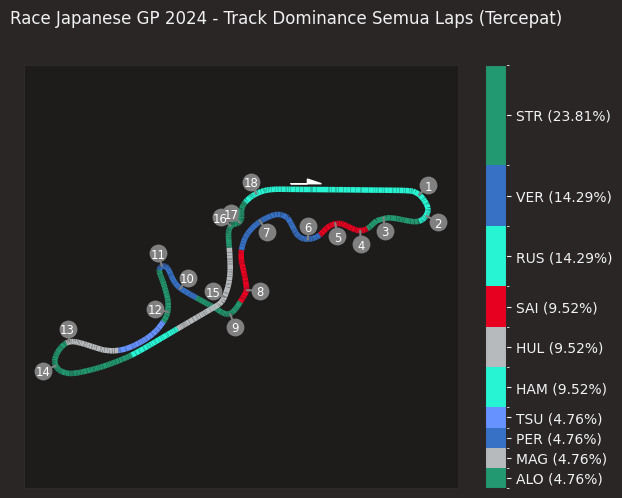

In [17]:
from matplotlib.colors import BoundaryNorm, ListedColormap
circRot=circuit_info.rotation
x,y=rotate_matrix(single_lap['X'].values,single_lap['Y'].values,circRot)


listProp.sort_values('proportion',inplace=True)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_avg=single_lap['idTeam'].to_numpy().astype(float)

#teamColor=single_lap[['id','tc']].drop_duplicates()
cmap = ListedColormap(single_lap['teamColor'].drop_duplicates().to_list())
lc_comp = LineCollection(segments, norm=plt.Normalize(0, cmap.N), cmap=cmap)
lc_comp.set_array(fastest_avg)
lc_comp.set_linewidth(4)


fig,ax=plt.subplots(figsize=(7,5.5))
    

fig.suptitle(
        f"Race Japanese GP 2024 - Track Dominance Semua Laps (Tercepat)"
    )
        
ax.add_collection(lc_comp)
ax.axis('equal')
ax.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

offset_vector = [700, 0] 
# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=math.radians(circRot))

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=math.radians(circRot))

    # Draw a circle next to the track.
    plt.scatter(text_x, text_y, color='grey', s=140)

    # Draw a line from the track to this circle.
    plt.plot([track_x, text_x], [track_y, text_y], color='grey')
    

    # Finally, print the corner number inside the circle.
    plt.text(text_x, text_y, txt,
             va='center_baseline', ha='center', size='small', color='white')
plt.arrow(x[0],y[0]+300,+900,0,color='white',shape='right',head_width=500)
bounds=[i*10 for i in(listProp.sort_values('proportion')['proportion'].to_list())]
bounds.insert(0,0)
boundsx=[]
mem=0
for i in bounds:
    i+=mem
    mem=i
    boundsx.append(i)


cmap = ListedColormap(listProp['teamColor'].to_list())
norm = BoundaryNorm(boundsx, cmap.N)

cbar=fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),ax=ax,spacing='proportional')
initial=0
ticksList=[]
for i in listProp['proportion']:
    if i!=0:
        ticksList.append((((i*10)/2)+initial))
        initial+=i*10

cbar.set_ticks(ticksList)
#listProp['bounds']=boundsx
labels=[]
for j,k in listProp.iterrows():
    label=f'{k["drvName"]} ({round(k["proportion"]*100,2)}%)'
    labels.append(label)

cbar.set_ticklabels(labels)#ambil driver name dari variabel!!!
plt.xticks([])
plt.yticks([])
plt.show()